### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


### Load the Data:

In [2]:
has_planets = pd.read_csv('../clean_planet_data/rand_non_null_planets.csv')

In [3]:
kep3 = pd.read_csv('../clean_planet_data/clean_cut_kepc3.csv')

In [4]:
k2c1 = pd.read_csv('../clean_planet_data/clean_cut_k2c1.csv')

### Preparing Training Set:
Mixing confirmed planets into data so the model can learn what they are like

In [5]:
kep3.shape

(5087, 3199)

In [6]:
k2c1.shape

(4550, 3199)

In [7]:
has_planets.shape

(1166, 3915)

In [8]:
# cut out the extra data to compare across the same timeline
join_planets = has_planets.iloc[:,:3199]
join_planets.shape

(1166, 3199)

In [9]:
# make sure the dataframes have the same column names
join_planets.columns = kep3.columns
# k2c1.columns = join_planets.columns

# label the confirmed planet systems with 1
join_planets['LABEL'] = 1
# k2c1['LABEL'] = 0

In [10]:
join_planets.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,KIC 10000941,1,52902.074219,52927.621094,52939.589844,52911.21875,52920.886719,52934.554688,52921.554688,52937.226562,...,50983.238281,50983.949219,50995.265625,50997.300781,50993.734375,51004.308594,50999.628906,51006.1875,51016.789062,51033.65625


In [11]:
kep3.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,NaN,1,93.85,83.81,20.1,-26.98,-39.56,-124.71,-135.18,-96.27,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54


In [12]:
master_df = pd.concat([join_planets, kep3], axis = 0)
master_df.head(1)

,name,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,KIC 10000941,1,52902.074219,52927.621094,52939.589844,52911.21875,52920.886719,52934.554688,52921.554688,52937.226562,...,50983.238281,50983.949219,50995.265625,50997.300781,50993.734375,51004.308594,50999.628906,51006.1875,51016.789062,51033.65625


In [13]:
master_df.shape

(6253, 3199)

In [14]:
# baseline accuracy
val_count = master_df['LABEL'].value_counts()
val_count

0    5050
1    1203
Name: LABEL, dtype: int64

In [15]:
base_acc = val_count[1] / val_count[0]
1 - base_acc

0.7617821782178218

In [16]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['LABEL']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [18]:
X_train = X_train.T
X_test = X_test.T

In [19]:
X_train.head(1)

,733,5060,1919,3874,814,651,1859,3286,3784,3421,...,3165,231,3026,720,141,1303,468,2619,2441,855
FLUX.1,3222.173096,9.8,92.6,-99.33,-310.74,-64.75,71.39,23.69,43.28,-47.53,...,173.19,-22.88,-44.26,10136.717773,53.27,-14.53,-16.01,-121.08,555.14,-14.04


In [20]:
X_test.head(1)

,3010,1062,2997,405,1819,106,302,875,1042,1273,...,267,4586,2016,2515,1913,434,2688,1055,3447,2461
FLUX.1,88.81,29071.822266,7.79,127.03,35.89,-419.5,-58.12,17636.148438,-63.12,157.89,...,10062.138672,256.86,19.46,-30.54,-0.47,43051.882812,85.55,7489.284668,2.14,25.88


In [21]:
# Scaling
ss = StandardScaler()

scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

#####FIXME!!!! you shouldn't be fit transforming, just transforming
test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

In [22]:
X_train = X_train.T
X_test = X_test.T

In [23]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
733,0.629739,-0.158673,2.565013,1.722023,1.052984,-0.062753,1.978416,0.765369,2.086230,0.880185,...,0.555641,-0.496502,-0.536068,-0.814571,0.220306,0.289608,0.255268,0.351620,-1.093074,-0.650261
5060,0.527118,1.203346,0.923368,0.712228,0.767182,0.743465,0.582651,0.685040,0.210118,0.064923,...,-1.002927,-1.137131,-0.200593,-0.126549,-0.294883,0.844118,-1.391656,-1.517762,-1.773444,-1.628828
1919,1.955487,0.371565,0.414987,0.298249,0.268792,0.140708,0.485248,0.337525,0.253736,0.192640,...,2.433566,2.286935,2.378798,2.344758,2.280607,2.334503,2.410437,2.929101,2.692135,2.752358
3874,-1.429572,-1.852530,-1.797694,-1.672870,-1.057553,-1.189881,-1.250922,-0.995935,-0.733877,-1.100845,...,0.231091,0.114925,0.219546,-0.236746,-0.100378,0.105257,0.842655,1.007163,0.609458,0.086064
814,-1.094364,-1.377672,-1.444957,-1.368818,-1.178719,-1.049991,-0.918324,-0.849481,-0.779433,-0.518896,...,-0.115325,-0.081435,-0.178503,-0.221778,-0.399057,-0.250427,-0.802877,-0.558524,-0.322706,-0.264274


### Modeling:

In [24]:
# Things to tune over
#     number of layers
#     order of layers
#     filters
#     filter size
#     nodes
#     regularization
# # Normalize outputs from previous layer.
# model.add(BatchNormalization())

# # Leaky ReLU activation function.
# model.add(LeakyReLU())

# try changing the learning rate
#     also the decay rate

# Things to try with the data itself
#     normalizing light data
#     combining confirmed planets with a different dataset
#     spline smoothing

# try changing the size of the neurons
#     meaning input dimensions?

In [25]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

In [59]:
# Define model architecture
model = Sequential()

# Convolutional layer.
model.add(Conv1D(filters = 1,      # number of filters, best tuning so far is 15 (hasn't generalized well yet though)
                 kernel_size = (50),  # filter size
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data

# # Convolutional layer
# model.add(Conv1D(filters = 1,
#                  kernel_size = 25,
#                  activation = 'relu'))

# # Convolutional layer
# model.add(Conv1D(filters = 1,
#                  kernel_size = 100,
#                  activation = 'relu'))

# dropout
# model.add(Dropout(0.5))

# Pooling layer.
model.add(MaxPooling1D(pool_size = (10))) 


# regularize
# model.add(Dropout(0.5))

# In order to go from a convolutional/pooling layer, we have to organize our neurons.
model.add(Flatten())

# Fully connected layer.
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.7)) # regularization

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Changing adam optimization parameters
optimizers.adam(lr = 0.001, decay = 0) # decay is thought to help the network learn good features first and then tune them

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [60]:
result = model.fit(X_array,
                    y_train,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 1,
                   validation_data = (X_test_array, y_test))

Train on 4689 samples, validate on 1564 samples
Epoch 1/10
4689/4689 [==============================] - 10s 2ms/step - loss: 0.4762 - acc: 0.7857 - val_loss: 0.3398 - val_acc: 0.8056
Epoch 2/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.3511 - acc: 0.8147 - val_loss: 0.2842 - val_acc: 0.8389
Epoch 3/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.3029 - acc: 0.8360 - val_loss: 0.2662 - val_acc: 0.8440
Epoch 4/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.2658 - acc: 0.8580 - val_loss: 0.2474 - val_acc: 0.9009
Epoch 5/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.2475 - acc: 0.8763 - val_loss: 0.2409 - val_acc: 0.9086
Epoch 6/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.2301 - acc: 0.8925 - val_loss: 0.2336 - val_acc: 0.9207
Epoch 7/10
4689/4689 [==============================] - 9s 2ms/step - loss: 0.2198 - acc: 0.9085 - val_loss: 0.2307 - val_acc: 0.9271
Epoch 8/10
46

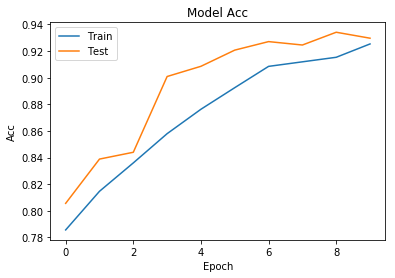

In [61]:
# Plot loss over time.
plt.figure()
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model Acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show();

### Testing on Unseen Data:
Now that the model is fit, lets see if we can use it to detect some planets in data not seen before.

In [31]:
unseen_data = k2c1.iloc[:,2:]
unseen_data.head()

,c_flux_0,c_flux_1,c_flux_2,c_flux_3,c_flux_4,c_flux_5,c_flux_6,c_flux_7,c_flux_8,c_flux_9,...,c_flux_3187,c_flux_3188,c_flux_3189,c_flux_3190,c_flux_3191,c_flux_3192,c_flux_3193,c_flux_3194,c_flux_3195,c_flux_3196
0,0.797703,0.337489,1.070445,1.399347,0.934250,0.791782,1.093755,1.064029,1.329841,1.146246,...,1.396245,0.990716,1.161137,0.966180,0.910268,1.164527,0.765165,1.177681,0.784532,1.089843
1,0.998968,0.998894,0.998955,0.998621,0.998439,0.998994,0.998742,0.998664,0.998694,0.998781,...,1.000220,1.000692,1.000997,1.000448,1.000945,1.000794,1.000559,1.000788,1.000380,1.000687
2,0.996723,0.998320,0.997118,0.971116,0.990362,0.991308,0.991578,0.990599,0.990659,0.990619,...,1.000624,1.000552,1.000657,1.000506,1.000490,1.000031,1.000094,0.999030,0.999984,1.000106
3,0.998933,1.000310,0.999227,0.961526,0.991401,0.990589,0.991505,0.991731,0.990664,0.989793,...,1.005189,1.008736,1.006125,1.005632,1.007761,1.005299,1.005760,1.006642,1.006663,1.006258
4,0.972796,0.972643,0.971650,0.956476,0.967577,0.968580,0.968739,0.971210,0.967761,0.968618,...,1.005380,1.015107,1.013607,1.013659,1.012339,1.012487,1.012683,1.013824,1.017875,1.013461


In [32]:
# scale
##########FIXME!!!!!! don't fit_transform, only fit to training data
unseen_data = unseen_data.T

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T

In [33]:
# unseen_data.head()

In [34]:
# Change the shape
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

### Predict!

In [67]:
# predict_proba or classification
#     both, so we know what the model thinks and how confident it is
y_unseen = model.predict_classes(array_unseen)

In [68]:
yhat_unseen = pd.DataFrame(y_unseen, columns=['prediction'])
# yhat_unseen.head(5)

In [69]:
val_counts = yhat_unseen['prediction'].value_counts()
print(val_counts[1]/val_counts.sum())
val_count

0.3923076923076923


0    5050
1    1203
Name: LABEL, dtype: int64

In [ ]:
yhat_unseen[yhat_unseen['prediction'] == 1]

In [ ]:
# take a look at the unseen data
x_axis = list(range(unseen_data.shape[1]-2))
plt.scatter(x_axis, unseen_data.iloc[4028, 2:])
# plt.ylim(-2, 2)

### Example of a Transit:

Text(0.5, 1.0, 'Possible Solar Flare')

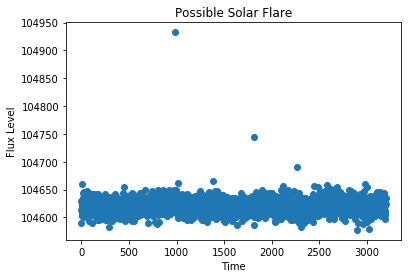

In [95]:
x_axis = list(range(join_planets.shape[1]-2))
plt.scatter(x_axis, join_planets.iloc[23, 2:])
# plt.ylim(10040, 10090)
plt.xlabel('Time')
plt.ylabel('Flux Level')
plt.title('Possible Solar Flare')

### Notes <hr>

In [ ]:
# # Evaluate model on test data
# score = model.evaluate(X_test_array, y_test, verbose = 1)
# labels = model.metrics_names

# score
# # labels
# # model.summary()

In [ ]:
# # What is the best way to do this?
# undersample?
# oversample?
# What is the best ratio?
# will this affect my result/ my false positive rate?

# change columns of kep3 so you can join it with the planet data
#     make sure there are no gaps in the confirmed planets data
#     or the other data
#     cut down dfs to be the right size
#     do I want to remove the confimed planets already in the kep3 set in case they are repeats?

# is it possible that some of the planets don't pass in front of their stars for the 66 days I'm looking at?
#     what proportion of exoplanets have orbits of less than 66 days?

# how am I going to deal with the nulls?
#     skip to the next nearest non-null value?
#     how many nulls in a row are there?
#     if this happens to almost all confirmed planets, its possible that the network may learn to find these "skips"
#         should I then just drop any rows with too many consecutive nans? 
#         Pretty much every one has a string of at least 40 consecutive nans
#     mean imputation may have a logical case here
#         it would make sense that the level of light is between previous value and the next one + random noise
#         what about for longer strings of missing values 
#         mean imputation could be good for avoiding creating false signals because of its smoothing effect
#         the disadvantages of mean imputation may not be important because I am basically using neural networks for pattern detection
#     maybe if it is a long string of missing values you want to skip to the next real data, 
#         mark if that had happened so I could tell if it contributes to false positives
#     drop rows with more than 150 nulls? there are only 8
#         1134    666
#         752     408
#         851     408
#         1105    408
#         441     408
#         832     285
#         871     230
#         762     230

# definitely get data on whether it is a binary star system or not
#     how to feed these single features to the neural networks to help with pattern detection?

# normalize the light curves

# print out confusion matrix and other classification metrics

# turn it into a gridsearch
#     have it save the results to be analyzed later
#     can I have it tune over generalizability to the unseen set?